### GOES-16 ABI and CUES

#### Analysis and plotting of snow surface and brightness temperatures (2017-2020)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator  ## Import MaxNLocator
import os
import datetime as dt
import xarray as xr
from scipy import stats
import re
from scipy.signal import argrelextrema, argrelmax

# pretty print++ and pretty print
import pprintpp
pprintpp.monkeypatch()
import pprint

import warnings
warnings.filterwarnings('ignore')

# Import functions for computing summary statistics
import resampled_stats as rs



/home/spestana/opt/anaconda3/envs/goes-linux/lib/python3.6/site-packages/pprintpp/__init__.py:171: UserWarning: 'pprint' has already been imported; monkeypatching won't work everywhere.
  warnings.warn("'pprint' has already been imported; monkeypatching "


In [2]:
# use this function to match the date/time of observations
def nearest(items, pivot):
    # https://stackoverflow.com/questions/32237862/find-the-closest-date-to-a-given-date
    return min(items, key=lambda x: abs(x - pivot))

# month of water year
def month_of_wy(month):
    ''' return month of wateryear (starting with October = 1, ending with September = 12)
    based on: https://stackoverflow.com/questions/52105804/how-to-convert-calendar-year-to-water-year-in-pandas'''
    if month>=10:
        return(month-9)
    else:
        return(month+3)

Set font sizes for plots

In [3]:
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

---

# Open dataset

CUES dataset which is the merged GOES-16 brightness temperature, GOES-16 ABI Cloud Mask, and CUES station data:

In [4]:
cues_ds = pd.read_pickle('data/goes-cues_2017-2020.pkl')
cues_ds = cues_ds.to_xarray().squeeze()

In [5]:
cues_ds['goes_cues_airtemp_diff'] = cues_ds.goes_tb_c - cues_ds['Platform temperature; platform temperature/relative humidity; (degrees Celsius)']
cues_ds['goes_cues_airtemp_diff_not_orthorectified'] = cues_ds.goes_tb_not_orthorectified_c - cues_ds['Platform temperature; platform temperature/relative humidity; (degrees Celsius)']

### Filter entire dataset to only snow-on conditions, cloud-free, November through June each year

Set thresholds for where we want to ignore snow surface temperature and GOES brightness temperature measurements. It looks like I can be safe by saying "no snow" is anywhere below 5 cm of snow depth. I'll use the daily median snow depth to check this.

And of course we want no cloud-cover, so only look at where ABI Cloud Mask=0.

There are very few data points within Fall months, and we don't want to look at the summer past snowmelt. Filter to only look at November through June each year.

In [6]:
# Set snow depth threshold for filtering data to snow-on conditions only
snow_depth_treshold = 5 # cm

##### Create a filter, combining the "snow-on" and "ABI cloud mask" filters
filter_conditions_ABIcloud_snowdepth_months = ((cues_ds.ABI_Cloud_Mask == 0) & \
                                               (cues_ds.daily_median_snow_depth >= snow_depth_treshold) & \
                                               (cues_ds.time.dt.month.isin([1,2,3,4,5,6,11,12])))
cues_snow_abicloud = cues_ds.where(filter_conditions_ABIcloud_snowdepth_months) # Apply this filter

---
---
---

# Summary stats for the full time period

And a plot showing the overal change due to orthorectifying the ABI imagery. Although we see a difference here in the timeseries, any "improvement" isn't really apparent. It is much more apparent when we look at the GOES versus ASTER plots when we can actually visually see the spatial misalignment without orthorectifying the GOES imagery.

Not Orthorectified (original ABI projection):
{
    'intercept': 3.458721393625364,
    'max_diff': 59.013285038444394,
    'mean_diff': 4.8946839657945445,
    'mean_squared_diff': 41.31325389186651,
    'median_diff': 5.141067905520024,
    'min_diff': -30.770639449525465,
    'n': 55013,
    'p_value': 0.0,
    'r_squared': 0.691700759754028,
    'r_value': 0.8316854932930043,
    'range_diff': 89.78392448796986,
    'rms_diff': 6.427538711813917,
    'slope': 0.8464428012554395,
    'std_diff': 4.165972007450399,
    'std_err': 0.0024093502963706027,
}
Orthorectified:
{
    'intercept': 1.998210801261779,
    'max_diff': 58.89857177734375,
    'mean_diff': 4.17591918252597,
    'mean_squared_diff': 33.69273150931101,
    'median_diff': 4.14581298828125,
    'min_diff': -21.426844482421874,
    'n': 55010,
    'p_value': 0.0,
    'r_squared': 0.687955385837275,
    'r_value': 0.8294307601224318,
    'range_diff': 80.32541625976562,
    'rms_diff': 5.804544039742571,
    'slope': 0.7

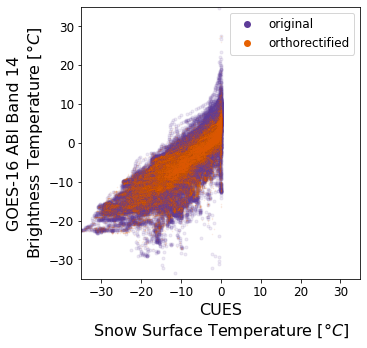

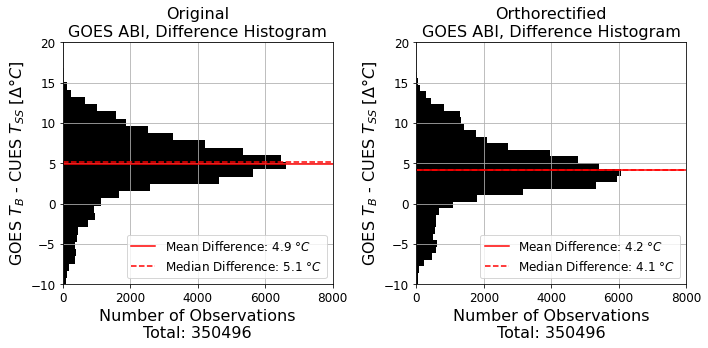

In [7]:
x1 = cues_snow_abicloud['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)']
y1 = cues_snow_abicloud.goes_tb_not_orthorectified_c

print("Not Orthorectified (original ABI projection):")
original_summary_stats = rs.summary_stats(x1, y1)
pprint.pprint(original_summary_stats)

x2 = cues_snow_abicloud['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)']
y2 = cues_snow_abicloud.goes_tb_c

print("Orthorectified:")
ortho_summary_stats = rs.summary_stats(x2, y2)
pprint.pprint(ortho_summary_stats)


### Make 1-to-1 plot
plt.figure(figsize=(5,5))

plt.plot(x1, y1, '.', color='#5e3c99', alpha=0.1, label='original GOES')
plt.plot(x2, y2, '.', color='#e66101', alpha=0.1,markersize=1, label='orthorectified GOES')


legend_elements= [Line2D([0], [0], marker='o', color='none', label='original',
                          markerfacecolor='#5e3c99', markeredgecolor='none', markersize=7),
                  Line2D([0], [0], marker='o', color='none', label='orthorectified',
                          markerfacecolor='#e66101', markeredgecolor='none', markersize=7)]
plt.legend(handles=legend_elements, loc='upper right')

plt.xlim((-35,35))
plt.ylim((-35,35));

plt.xlabel('CUES\nSnow Surface Temperature [$\degree C$]')
plt.ylabel('GOES-16 ABI Band 14\nBrightness Temperature [$\degree C$]');

### Make histograms


nbins=100
xmin=0
xmax=8000
ymin=-10
ymax=20


fig, [ax1, ax2] = plt.subplots(1,2,figsize=(10,5),tight_layout=True)

# original, not-orthorectified, difference histogram
cues_snow_abicloud.goes_cues_diff_not_orthorectified.plot.hist(ax=ax1,
                                                                  bins=nbins, 
                                                                  orientation='horizontal',
                                                                  color = '#000000',
                                                                  ec='none',
                                                                  lw=1)
#ax1.axhline(0,color='lightgrey',linestyle='-')
ax1.grid('on')
ax1.set_title('Original\nGOES ABI, Difference Histogram')
ax1.set_xlabel('Number of Observations\nTotal: {}'.format(cues_snow_abicloud.goes_cues_diff_not_orthorectified.size))
ax1.set_xlim((xmin,xmax))
ax1.set_ylim(ymin,ymax);
ax1.set_ylabel('GOES $T_{B}$ - CUES $T_{SS}$ [$\Delta\degree C$]')
ax1.axhline(original_summary_stats['mean_diff'], color='r', label='Mean Difference: {} $\degree C$'.format(np.round(original_summary_stats['mean_diff'],1)))
ax1.axhline(original_summary_stats['median_diff'], color='r', linestyle='--', label='Median Difference: {} $\degree C$'.format(np.round(original_summary_stats['median_diff'],1)))
ax1.legend(loc='lower right')

# orthorectified difference histogram

### Original Dataframe, Histogram ###
cues_snow_abicloud.goes_cues_diff.plot.hist(ax=ax2,
                                               bins=nbins, 
                                               orientation='horizontal',
                                               color = '#000000',
                                               ec='none',
                                               lw=1)
#ax2.axhline(0,color='lightgrey',linestyle='-')
ax2.grid('on')
ax2.set_title('Orthorectified\nGOES ABI, Difference Histogram')
ax2.set_xlabel('Number of Observations\nTotal: {}'.format(cues_snow_abicloud.goes_cues_diff.size))
ax2.set_xlim((xmin,xmax))
ax2.set_ylim(ymin,ymax);
ax2.set_ylabel('GOES $T_{B}$ - CUES $T_{SS}$ [$\Delta\degree C$]')
ax2.axhline(ortho_summary_stats['mean_diff'], color='r', label='Mean Difference: {} $\degree C$'.format(np.round(ortho_summary_stats['mean_diff'],1)))
ax2.axhline(ortho_summary_stats['median_diff'], color='r', linestyle='--', label='Median Difference: {} $\degree C$'.format(np.round(ortho_summary_stats['median_diff'],1)))
ax2.legend(loc='lower right')

Not Orthorectified (original ABI projection):
{
    'intercept': -3.5801123775943315,
    'max_diff': 38.75328503844439,
    'mean_diff': -3.578601778968889,
    'mean_squared_diff': 23.266161799197533,
    'median_diff': -3.50607571576362,
    'min_diff': -44.608552983491364,
    'n': 55428,
    'p_value': 0.0,
    'r_squared': 0.8250098873845477,
    'r_value': 0.9083005490389994,
    'range_diff': 83.36183802193575,
    'rms_diff': 4.823500989861776,
    'slope': 0.9942601085869297,
    'std_diff': 3.2341569391045693,
    'std_err': 0.001945003669557759,
}
Orthorectified:
{
    'intercept': -4.387073512568669,
    'max_diff': 38.47690795898437,
    'mean_diff': -4.364448478608568,
    'mean_squared_diff': 26.398700010477842,
    'median_diff': -4.341602172851559,
    'min_diff': -44.23747253417969,
    'n': 55425,
    'p_value': 0.0,
    'r_squared': 0.8565081661164827,
    'r_value': 0.9254772639651839,
    'range_diff': 82.71438049316406,
    'rms_diff': 5.137966524849869,
    'sl

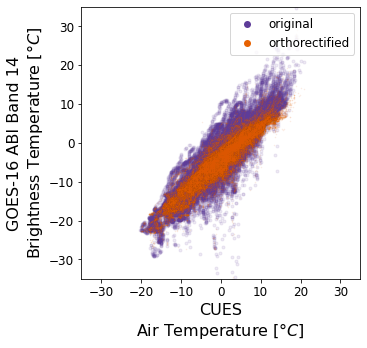

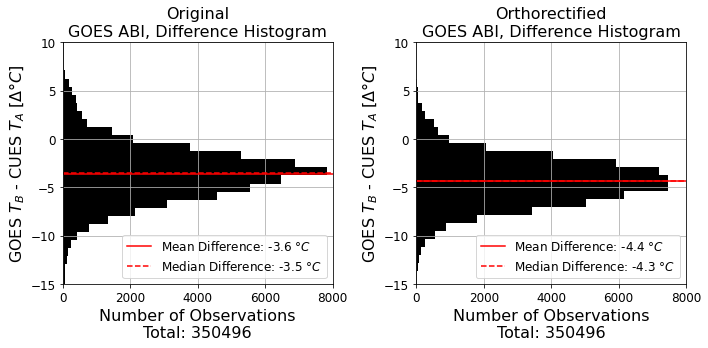

In [8]:
x1 = cues_snow_abicloud['Platform temperature; platform temperature/relative humidity; (degrees Celsius)']
y1 = cues_snow_abicloud.goes_tb_not_orthorectified_c

print("Not Orthorectified (original ABI projection):")
original_summary_stats = rs.summary_stats(x1, y1)
pprint.pprint(original_summary_stats)

x2 = cues_snow_abicloud['Platform temperature; platform temperature/relative humidity; (degrees Celsius)']
y2 = cues_snow_abicloud.goes_tb_c

print("Orthorectified:")
ortho_summary_stats = rs.summary_stats(x2, y2)
pprint.pprint(ortho_summary_stats)


### Make 1-to-1 plot
plt.figure(figsize=(5,5))

plt.plot(x1, y1, '.', color='#5e3c99', alpha=0.1, label='original GOES')
plt.plot(x2, y2, '.', color='#e66101', alpha=0.1,markersize=1, label='orthorectified GOES')


legend_elements= [Line2D([0], [0], marker='o', color='none', label='original',
                          markerfacecolor='#5e3c99', markeredgecolor='none', markersize=7),
                  Line2D([0], [0], marker='o', color='none', label='orthorectified',
                          markerfacecolor='#e66101', markeredgecolor='none', markersize=7)]
plt.legend(handles=legend_elements, loc='upper right')

plt.xlim((-35,35))
plt.ylim((-35,35));

plt.xlabel('CUES\nAir Temperature [$\degree C$]')
plt.ylabel('GOES-16 ABI Band 14\nBrightness Temperature [$\degree C$]');

### Make histograms


nbins=100
xmin=0
xmax=8000
ymin=-15
ymax=10


fig, [ax1, ax2] = plt.subplots(1,2,figsize=(10,5),tight_layout=True)

# original, not-orthorectified, difference histogram
cues_snow_abicloud.goes_cues_airtemp_diff_not_orthorectified.plot.hist(ax=ax1,
                                                                  bins=nbins, 
                                                                  orientation='horizontal',
                                                                  color = '#000000',
                                                                  ec='none',
                                                                  lw=1)
#ax1.axhline(0,color='lightgrey',linestyle='-')
ax1.grid('on')
ax1.set_title('Original\nGOES ABI, Difference Histogram')
ax1.set_xlabel('Number of Observations\nTotal: {}'.format(cues_snow_abicloud.goes_cues_airtemp_diff_not_orthorectified.size))
ax1.set_xlim((xmin,xmax))
ax1.set_ylim(ymin,ymax);
ax1.set_ylabel('GOES $T_{B}$ - CUES $T_{A}$ [$\Delta\degree C$]')
ax1.axhline(original_summary_stats['mean_diff'], color='r', label='Mean Difference: {} $\degree C$'.format(np.round(original_summary_stats['mean_diff'],1)))
ax1.axhline(original_summary_stats['median_diff'], color='r', linestyle='--', label='Median Difference: {} $\degree C$'.format(np.round(original_summary_stats['median_diff'],1)))
ax1.legend(loc='lower right')

# orthorectified difference histogram

### Original Dataframe, Histogram ###
cues_snow_abicloud.goes_cues_airtemp_diff.plot.hist(ax=ax2,
                                               bins=nbins, 
                                               orientation='horizontal',
                                               color = '#000000',
                                               ec='none',
                                               lw=1)
#ax2.axhline(0,color='lightgrey',linestyle='-')
ax2.grid('on')
ax2.set_title('Orthorectified\nGOES ABI, Difference Histogram')
ax2.set_xlabel('Number of Observations\nTotal: {}'.format(cues_snow_abicloud.goes_cues_airtemp_diff.size))
ax2.set_xlim((xmin,xmax))
ax2.set_ylim(ymin,ymax);
ax2.set_ylabel('GOES $T_{B}$ - CUES $T_{A}$ [$\Delta\degree C$]')
ax2.axhline(ortho_summary_stats['mean_diff'], color='r', label='Mean Difference: {} $\degree C$'.format(np.round(ortho_summary_stats['mean_diff'],1)))
ax2.axhline(ortho_summary_stats['median_diff'], color='r', linestyle='--', label='Median Difference: {} $\degree C$'.format(np.round(ortho_summary_stats['median_diff'],1)))
ax2.legend(loc='lower right')

---
ASTER, MODIS, GOES timeseries for CUES:

In [9]:
#sat_timeseries = pd.read_csv('goes_modis_aster_orthorectified_tb_cues_timeseries.csv')
#sat_timeseries['time'] = pd.to_datetime(sat_timeseries['time'])
#sat_timeseries.set_index('time', inplace=True)
## Drop 2020-03-05 18:45:35, CUES has clouds then
#sat_timeseries.drop(sat_timeseries.index[25], inplace=True)
#sat_timeseries['ast_goes_max_diff_rad2tbK'] = sat_timeseries.ast_goes_goes_tb - sat_timeseries.ast_goes_max_rad2tbK
#sat_timeseries['ast_goes_min_diff_rad2tbK'] = sat_timeseries.ast_goes_goes_tb - sat_timeseries.ast_goes_min_rad2tbK

In [10]:
#x = sat_timeseries.index.dayofyear
#
#plt.plot(x, sat_timeseries.ast_goes_aster_rad2tbK, 
#         linestyle='none', marker='o', color='r', label='ASTER pixel Tb')
#
#plt.plot(x, sat_timeseries.ast_goes_mean_rad2tbK, 
#         linestyle='none', marker='o', color='k', label='ASTER upscaled to GOES resolution Tb')
#
#plt.errorbar(x=x, 
#             y=sat_timeseries.ast_goes_mean_rad2tbK, 
#             yerr=[sat_timeseries.ast_goes_mean_rad2tbK-sat_timeseries.ast_goes_min_rad2tbK, 
#                   sat_timeseries.ast_goes_max_rad2tbK-sat_timeseries.ast_goes_mean_rad2tbK],
#             fmt='none', label='min/max ASTER Tb within GOES pixel footprint', color='k', linewidth=1, capsize=3)
#
#plt.plot(x, sat_timeseries.ast_goes_goes_tb, 
#         linestyle='none', marker='o', color='b', label='GOES Tb')
#
#plt.legend(loc=(1.1,0.5))

---

# Boxplots and Histograms

Resample, compute summary stats

In [11]:
SMALL_SIZE = 10
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### 1M resample

Summary Stats for full cues_snow_cloud dataset
{
    'intercept': 1.998210801261779,
    'max_diff': 58.89857177734375,
    'mean_diff': 4.17591918252597,
    'mean_squared_diff': 33.69273150931101,
    'median_diff': 4.14581298828125,
    'min_diff': -21.426844482421874,
    'n': 55010,
    'p_value': 0.0,
    'r_squared': 0.687955385837275,
    'r_value': 0.8294307601224318,
    'range_diff': 80.32541625976562,
    'rms_diff': 5.804544039742571,
    'slope': 0.7671291672308391,
    'std_diff': 4.031678371388602,
    'std_err': 0.002202844169854027,
}


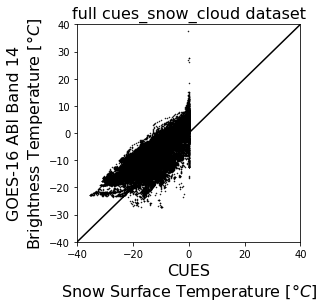

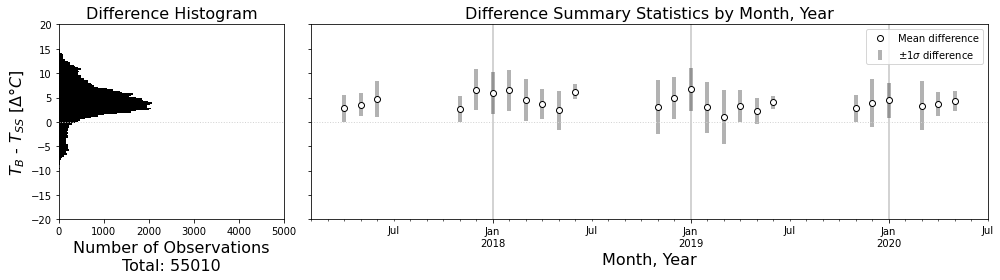

In [12]:
# Compute summary stats for whole dataset
x = cues_snow_abicloud['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)']
y = cues_snow_abicloud.goes_tb_c
print("Summary Stats for full cues_snow_cloud dataset")
original_summary_stats = rs.summary_stats(x, y)
pprint.pprint(original_summary_stats)
# Make a 1-to-1 plot for the same data in the histogram
plt.figure(figsize=(4,4))
plt.title('full cues_snow_cloud dataset')
plt.plot(x, y, '.k',alpha=1, markersize=1)
(min_lim, max_lim) = (-40, 40)
plt.xlim((min_lim,max_lim))
plt.ylim((min_lim,max_lim));
plt.xlabel('CUES\nSnow Surface Temperature [$\degree C$]')
plt.ylabel('GOES-16 ABI Band 14\nBrightness Temperature [$\degree C$]');
plt.plot([min_lim,max_lim],[min_lim,max_lim],'-k')

# Create DataArrayResample object
resampled_ds = cues_snow_abicloud.goes_cues_diff.resample(time='1M')
# Run the resampled_stats function
resampled_df = rs.resampled_stats(resampled_ds, 0)

startdate = pd.Timestamp('2017-02-01')
enddate = pd.Timestamp('2020-07-01')

# Plot the results
fig, ax = rs.resampled_plot(cues_snow_abicloud.goes_cues_diff.to_dataframe(), resampled_df, ymin=-20, ymax=20, xmin=0, xmax=5000, nbins=300)
# Add grid
ax[1].grid(which='major', axis='x', color='lightgrey', lw=2)
ax[1].set_xlim((startdate,enddate));
ax[1].set_title('Difference Summary Statistics by Month, Year');
ax[1].set_xlabel('Month, Year');
#
### add snow depth line for context
#snowdepth_ax = ax[1].twiny().twinx()
#snowdepth_ax.set_xlim((startdate,enddate));
#snowdepth_ax.set_xticklabels([])
#cues_ds.daily_median_snow_depth.plot(color='red',label='Daily Median Snow Depth', ax=snowdepth_ax, alpha=0.5)
#snowdepth_ax.set_ylabel('Snow Depth [cm]')
##snowdepth_ax.legend(loc='upper right')

Summary Stats for full cues_snow_cloud dataset
{
    'intercept': -4.387073512568669,
    'max_diff': 38.47690795898437,
    'mean_diff': -4.364448478608568,
    'mean_squared_diff': 26.398700010477842,
    'median_diff': -4.341602172851559,
    'min_diff': -44.23747253417969,
    'n': 55425,
    'p_value': 0.0,
    'r_squared': 0.8565081661164827,
    'r_value': 0.9254772639651839,
    'range_diff': 82.71438049316406,
    'rms_diff': 5.137966524849869,
    'slope': 0.9140951570965806,
    'std_diff': 2.7111417314572837,
    'std_err': 0.0015892573625554188,
}


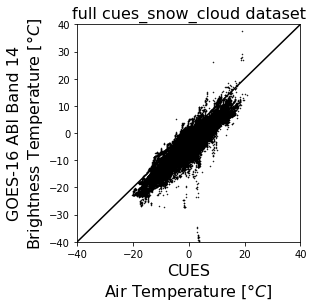

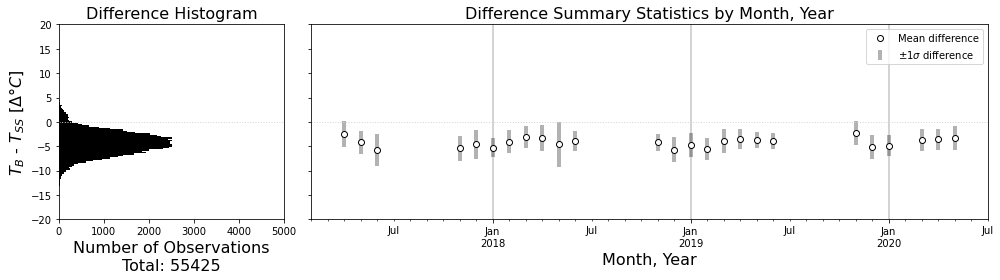

In [13]:
# Compute summary stats for whole dataset
x = cues_snow_abicloud['Platform temperature; platform temperature/relative humidity; (degrees Celsius)']
y = cues_snow_abicloud.goes_tb_c
print("Summary Stats for full cues_snow_cloud dataset")
original_summary_stats = rs.summary_stats(x, y)
pprint.pprint(original_summary_stats)
# Make a 1-to-1 plot for the same data in the histogram
plt.figure(figsize=(4,4))
plt.title('full cues_snow_cloud dataset')
plt.plot(x, y, '.k',alpha=1, markersize=1)
(min_lim, max_lim) = (-40, 40)
plt.xlim((min_lim,max_lim))
plt.ylim((min_lim,max_lim));
plt.xlabel('CUES\nAir Temperature [$\degree C$]')
plt.ylabel('GOES-16 ABI Band 14\nBrightness Temperature [$\degree C$]');
plt.plot([min_lim,max_lim],[min_lim,max_lim],'-k')

# Create DataArrayResample object
resampled_ds = cues_snow_abicloud.goes_cues_airtemp_diff.resample(time='1M')
# Run the resampled_stats function
resampled_df = rs.resampled_stats(resampled_ds, 0)

startdate = pd.Timestamp('2017-02-01')
enddate = pd.Timestamp('2020-07-01')

# Plot the results
fig, ax = rs.resampled_plot(cues_snow_abicloud.goes_cues_airtemp_diff.to_dataframe(), resampled_df, ymin=-20, ymax=20, xmin=0, xmax=5000, nbins=300)
# Add grid
ax[1].grid(which='major', axis='x', color='lightgrey', lw=2)
ax[1].set_xlim((startdate,enddate));
ax[1].set_title('Difference Summary Statistics by Month, Year');
ax[1].set_xlabel('Month, Year');

### Month of Year groupby

In [20]:
## Create DataArrayResample object
#resampled_ds = cues_snow_abicloud.goes_cues_diff.groupby('time.month')
## Run the resampled_stats function
#resampled_df = rs.resampled_stats(resampled_ds, 0)
#
## calculate month of wateryear from calendar month
#resampled_df['month_of_wateryear'] = [month_of_wy(month) for month in resampled_df.index]
#resampled_df.set_index('month_of_wateryear', inplace=True)
#
## Plot the results
#fig, ax = rs.resampled_plot2(cues_snow_abicloud.goes_cues_diff.to_dataframe(), resampled_df, ymin=-20, ymax=20, xmin=0, xmax=5000, nbins=300)
#
#### Add GOES-ASTER difference by hour of day for this month
##x = [month_of_wy(month) for month in sat_timeseries.index.month.values] # Get month of wy
##y = sat_timeseries.ast_goes_mean_diff_tb # Get GOES-ASTER mean difference for this month
##yerr_min = sat_timeseries.ast_goes_min_diff_rad2tbK
##yerr_max = sat_timeseries.ast_goes_max_diff_rad2tbK
##_yerr_min = yerr_min.groupby(yerr_min.index.month).min() # groupby month, monthly minimum
##_yerr_max = yerr_max.groupby(yerr_max.index.month).max() # groupby month, monthly maximum
##_y = y.groupby(y.index.month).mean() # groupby month mean
##_x = [month_of_wy(month) for month in _y.index.values] # get wateryear months from groupby month y data series
###ax[1].errorbar(x, y, yerr=[yerr_min, yerr_max], fmt='o', color='r', linewidth=1, capsize=3, zorder=0)
##ax[1].errorbar(_x, _y, yerr=[_yerr_min, _yerr_max], fmt='o', color='r', linewidth=1, capsize=3, zorder=0, label='GOES-ASTER mean and min/max difference')
#       
## format axis, limits and labels
#ax[0].set_ylim((-10,15))
#ax[0].set_xlim((0,2500))
#ax[1].set_xlim((1,10))
#ax[1].set_xticks(np.arange(2, 10, 1.0))
#month_labels = [  'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun']
#ax[1].set_xticklabels(month_labels)
#ax[0].set_title('GOES $T_{B}$ - CUES $T_{SS}$\nDifference Histogram')
#ax[0].set_ylabel('$T_{B}$ - $T_{SS}$ [$\Delta\degree C$]')
#ax[1].set_title('GOES $T_{B}$ - CUES $T_{SS}$\nDifference by Month')
#ax[1].set_xlabel('Month')
#ax[1].legend(loc='lower right')
#
#print(resampled_df)

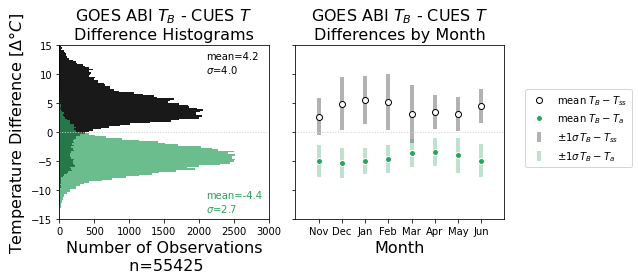

In [15]:
# Create DataArrayResample object
resampled_ds_tss = cues_snow_abicloud.goes_cues_diff.groupby('time.month')
# Run the resampled_stats function
resampled_df_tss = rs.resampled_stats(resampled_ds_tss, 0)
# calculate month of wateryear from calendar month
resampled_df_tss['month_of_wateryear'] = [month_of_wy(month) for month in resampled_df_tss.index]
resampled_df_tss.set_index('month_of_wateryear', inplace=True)
#print("Snow Surface Temperature:\n", resampled_df_tss)

# Create DataArrayResample object
resampled_ds_tair = cues_snow_abicloud.goes_cues_airtemp_diff.groupby('time.month')
# Run the resampled_stats function
resampled_df_tair = rs.resampled_stats(resampled_ds_tair, 0)
# calculate month of wateryear from calendar month
resampled_df_tair['month_of_wateryear'] = [month_of_wy(month) for month in resampled_df_tair.index]
resampled_df_tair.set_index('month_of_wateryear', inplace=True)
#print("Snow Surface Temperature:\n", resampled_df_tair)


# Plot the results
fig, ax = rs.resampled_plot3(cues_snow_abicloud.goes_cues_diff.to_dataframe(), resampled_df_tss, 
                             cues_snow_abicloud.goes_cues_airtemp_diff.to_dataframe(), resampled_df_tair,
                             ymin=-20, ymax=20, xmin=0, xmax=5000, nbins=300)

### Add GOES-ASTER difference by hour of day for this month
#x = [month_of_wy(month) for month in sat_timeseries.index.month.values] # Get month of wy
#y = sat_timeseries.ast_goes_mean_diff_tb # Get GOES-ASTER mean difference for this month
#yerr_min = sat_timeseries.ast_goes_min_diff_rad2tbK
#yerr_max = sat_timeseries.ast_goes_max_diff_rad2tbK
#_yerr_min = yerr_min.groupby(yerr_min.index.month).min() # groupby month, monthly minimum
#_yerr_max = yerr_max.groupby(yerr_max.index.month).max() # groupby month, monthly maximum
#_y = y.groupby(y.index.month).mean() # groupby month mean
#_x = [month_of_wy(month) for month in _y.index.values] # get wateryear months from groupby month y data series
##ax[1].errorbar(x, y, yerr=[yerr_min, yerr_max], fmt='o', color='r', linewidth=1, capsize=3, zorder=0)
#ax[1].errorbar(_x, _y, yerr=[_yerr_min, _yerr_max], fmt='o', color='r', linewidth=1, capsize=3, zorder=0, label='GOES-ASTER mean and min/max difference')
       
# format axis, limits and labels
ax[0].set_ylim((-15,15))
ax[0].set_xlim((0,3000))
ax[1].set_xlim((1,10))
ax[1].set_xticks(np.arange(2, 10, 1.0))
month_labels = [  'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun']
ax[1].set_xticklabels(month_labels)
ax[0].set_title('GOES ABI $T_{B}$ - CUES $T_{}$\nDifference Histograms')
ax[0].set_ylabel('Temperature Difference [$\Delta\degree C$]')
ax[1].set_title('GOES ABI $T_{B}$ - CUES $T_{}$\nDifferences by Month')
ax[1].set_xlabel('Month')
ax[1].legend(loc=(1.1,.3))



### Week of Year groupby

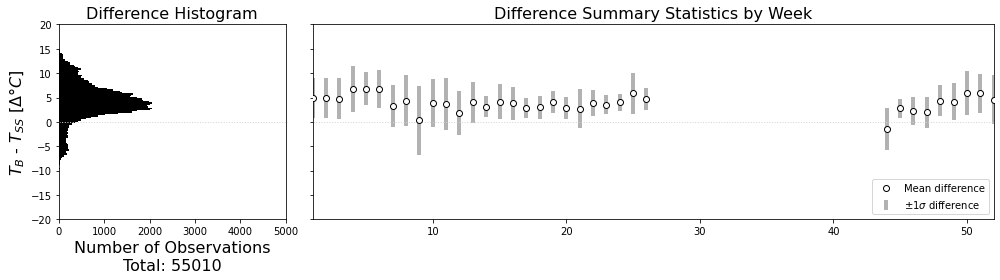

In [16]:
# Create DataArrayResample object
resampled_ds = cues_snow_abicloud.goes_cues_diff.groupby('time.week')
# Run the resampled_stats function
resampled_df = rs.resampled_stats(resampled_ds, 0)


def week_of_wy(week):
    ''' return week of wateryear (starting with 1st week of October = 1, ending with last week of September = 52)
    based on: https://stackoverflow.com/questions/52105804/how-to-convert-calendar-year-to-water-year-in-pandas'''
    if week>=40:
        return(week-39)
    else:
        return(week+13)

# calculate month of wateryear from calendar month
resampled_df['week_of_wateryear'] = [week_of_wy(week) for week in resampled_df.index]
#resampled_df.set_index('week_of_wateryear', inplace=True)

# Plot the results
fig, ax = rs.resampled_plot(cues_snow_abicloud.goes_cues_diff.to_dataframe(), resampled_df, ymin=-20, ymax=20, xmin=0, xmax=5000, nbins=300)

## Add GOES-ASTER difference by hour of day for this month
#x = sat_timeseries.index.week # Get weeks
#y = sat_timeseries.ast_goes_mean_diff_tb # Get GOES-ASTER mean difference for this month
#yerr_min = y - (sat_timeseries.ast_goes_goes_tb - sat_timeseries.ast_goes_min_rad2tbK)
#yerr_max = (sat_timeseries.ast_goes_goes_tb - sat_timeseries.ast_goes_max_rad2tbK) - y
#ax[1].errorbar(x, y, yerr=[yerr_min, yerr_max], fmt='o', color='r', linewidth=1, capsize=3)
        

# format axis, limits and labels
#ax[1].set_xlim((0,44))
#ax[1].set_xticks(np.concatenate((np.arange(40,52), np.arange(0,39))))
#month_labels = [ 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun']
#ax[1].set_xticklabels(month_labels)
ax[1].set_title('Difference Summary Statistics by Week')
ax[1].set_xlabel('')
ax[1].legend(loc='lower right')

### Hour of Day groupby

Summary Stats:
{
    'intercept': 1.998210801261779,
    'max_diff': 58.89857177734375,
    'mean_diff': 4.17591918252597,
    'mean_squared_diff': 33.69273150931101,
    'median_diff': 4.14581298828125,
    'min_diff': -21.426844482421874,
    'n': 55010,
    'p_value': 0.0,
    'r_squared': 0.687955385837275,
    'r_value': 0.8294307601224318,
    'range_diff': 80.32541625976562,
    'rms_diff': 5.804544039742571,
    'slope': 0.7671291672308391,
    'std_diff': 4.031678371388602,
    'std_err': 0.002202844169854027,
}


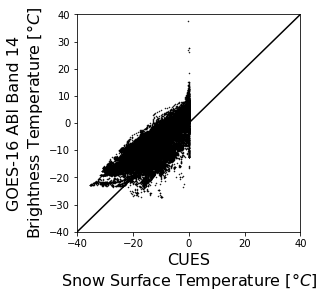

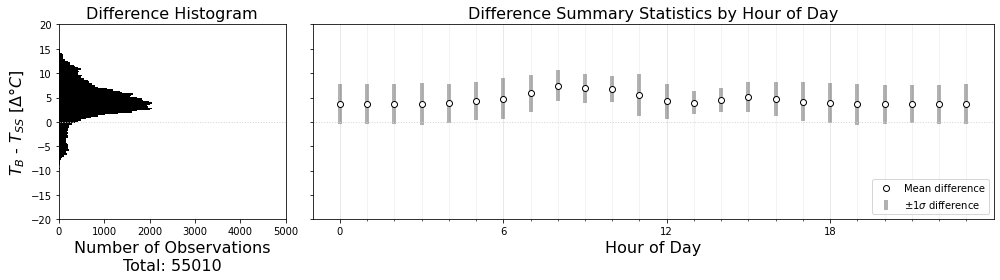

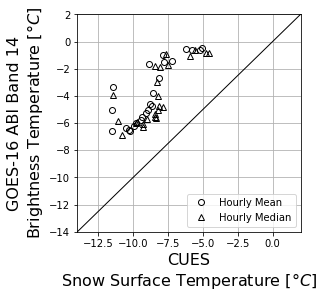

In [17]:
df_m = cues_snow_abicloud.to_dataframe()

        
# Compute summary stats
x = df_m['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)']
y = df_m.goes_tb_c
print('Summary Stats:')
original_summary_stats = rs.summary_stats(x, y)
pprint.pprint(original_summary_stats)
# Make a 1-to-1 plot for the same data in the histogram
plt.figure(figsize=(4,4))
plt.title('')
plt.plot(x, y, '.k',alpha=1, markersize=1)
(min_lim, max_lim) = (-40, 40)
plt.xlim((min_lim,max_lim))
plt.ylim((min_lim,max_lim));
plt.xlabel('CUES\nSnow Surface Temperature [$\degree C$]')
plt.ylabel('GOES-16 ABI Band 14\nBrightness Temperature [$\degree C$]');
plt.plot([min_lim,max_lim],[min_lim,max_lim],'-k')

# Create DataArrayResample object
resampled_ds = df_m.groupby(df_m.index.hour)
# Run the resampled_stats function
resampled_df = rs.resampled_stats(resampled_ds.goes_cues_diff, 0)

# Plot the results
nbins = 300#int(np.sqrt(df_m.goes_cues_diff.count()))+1
fig, ax = rs.resampled_plot(df_m.goes_cues_diff, resampled_df, ymin=-20, ymax=20, xmin=0, xmax=5000, nbins=nbins)
## Add GOES-ASTER difference by hour of day for this month
#x = sat_timeseries.index.hour # Get hour of day
#y = sat_timeseries.ast_goes_mean_diff_tb # Get GOES-ASTER mean difference
#yerr_min = y - (sat_timeseries.ast_goes_goes_tb - sat_timeseries.ast_goes_min_rad2tbK)
#yerr_max = (sat_timeseries.ast_goes_goes_tb - sat_timeseries.ast_goes_max_rad2tbK) - y
#ax[1].errorbar(x, y, yerr=[yerr_min, yerr_max], fmt='o', color='r', linewidth=1, capsize=3)
ax[1].set_title('Difference Summary Statistics by Hour of Day')
ax[1].set_xlabel('Hour of Day')
ax[1].legend(loc='lower right')
# Set major ticks and add grid
ax[1].set_xticks(np.arange(0,24,6))
ax[1].set_xticks(np.arange(0,24,1), minor = True)
ax[1].set_xlim((-1,24))
ax[1].grid(which='major', axis='x', color='lightgrey', lw=1, alpha=0.5);
ax[1].grid(which='minor', axis='x', color='lightgrey', lw=1, alpha=0.25);

### add another 1-to-1 plot
resampled_x = resampled_ds['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)']
resampled_y = resampled_ds.goes_tb_c
fig3, ax3 = plt.subplots(figsize=(4,4))
ax3.plot(rs.resampled_stats(resampled_x, 0)['means'], rs.resampled_stats(resampled_y, 0)['means'], linestyle='none',marker='o',markerfacecolor='none',markeredgecolor='k', zorder=99, label='Hourly Mean')
ax3.plot(rs.resampled_stats(resampled_x, 0)['medians'], rs.resampled_stats(resampled_y, 0)['medians'], linestyle='none',marker='^',markerfacecolor='none',markeredgecolor='k', zorder=98, label='Hourly Median')
#ax3.plot(rs.resampled_stats(resampled_x, 0)['modes'], rs.resampled_stats(resampled_y, 0)['modes'], linestyle='none',marker='+',color='k', zorder=97, label='Hourly Mode')
ax_lim_min = -14 #min(-5, ax3.get_xlim()[0], ax3.get_ylim()[0])
ax_lim_max = 2#max(5, ax3.get_xlim()[1], ax3.get_ylim()[1])
ax3.plot([ax_lim_min,ax_lim_max],[ax_lim_min,ax_lim_max],linestyle='-',color='k', lw=1)
ax3.grid('on')
ax3.set_xlim((ax_lim_min,ax_lim_max))
ax3.set_ylim((ax_lim_min,ax_lim_max))
ax3.set_xlabel('CUES\nSnow Surface Temperature [$\degree C$]')
ax3.set_ylabel('GOES-16 ABI Band 14\nBrightness Temperature [$\degree C$]');
ax3.legend(loc='lower right')

### Hour of Day, by Month groupby

T_B - T_ss, Month: 3
{
    'intercept': -3.207126136071089,
    'max_diff': 13.702971191406249,
    'mean_diff': 3.2109822282726155,
    'mean_squared_diff': 35.838068695808026,
    'median_diff': 3.966527099609374,
    'min_diff': -15.844842529296875,
    'n': 6115,
    'p_value': 0.0,
    'r_squared': 0.4225070869001661,
    'r_value': 0.6500054514388061,
    'range_diff': 29.547813720703125,
    'rms_diff': 5.986490515803731,
    'slope': 0.5209303737242432,
    'std_diff': 5.05249065565939,
    'std_err': 0.007789486214754686,
}
T_B - T_air, Month: 3
{
    'intercept': -4.000393024080965,
    'max_diff': 9.998470458984375,
    'mean_diff': -3.5454762072684036,
    'mean_squared_diff': 18.04089600411937,
    'median_diff': -3.5122314453125,
    'min_diff': -18.338440551757813,
    'n': 6115,
    'p_value': 0.0,
    'r_squared': 0.8040187870950193,
    'r_value': 0.8966709469448753,
    'range_diff': 28.336911010742188,
    'rms_diff': 4.24745759297481,
    'slope': 0.931494211240948

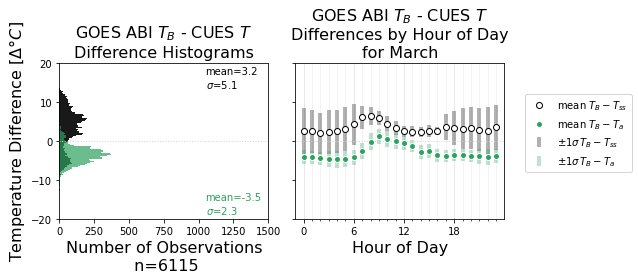

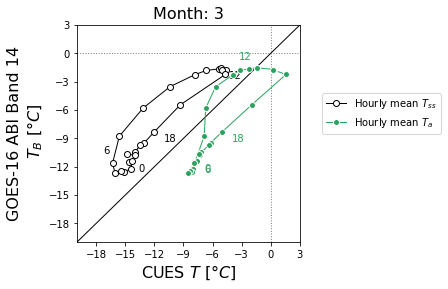

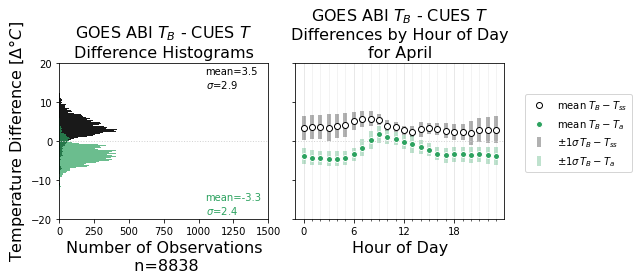

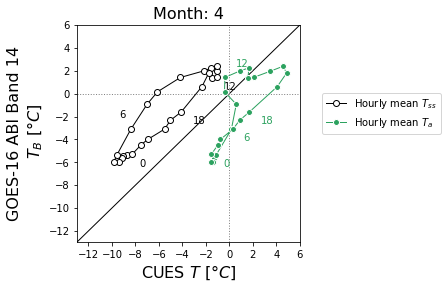

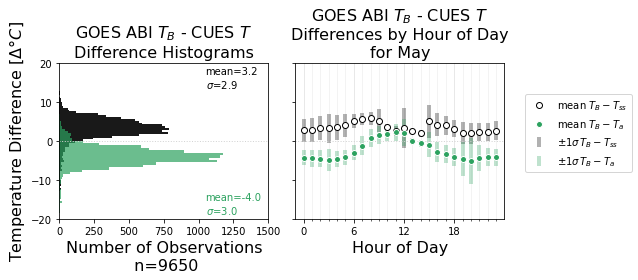

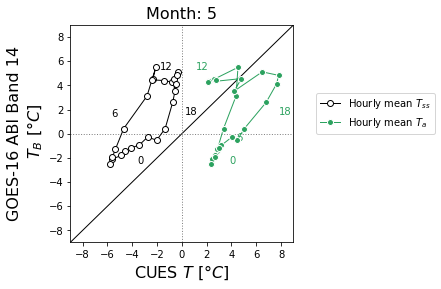

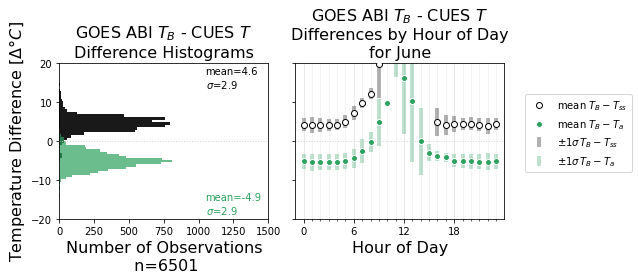

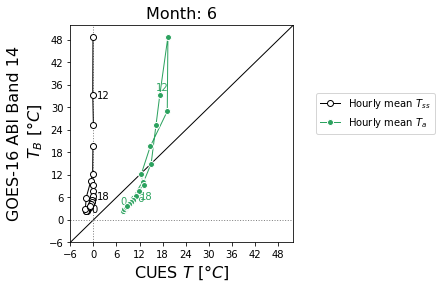

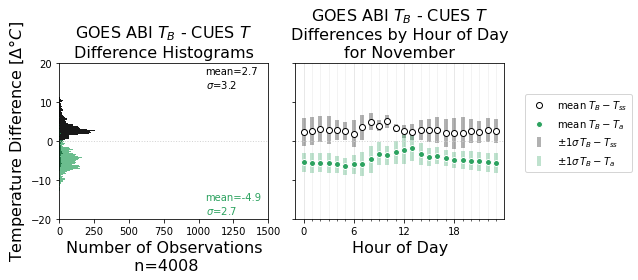

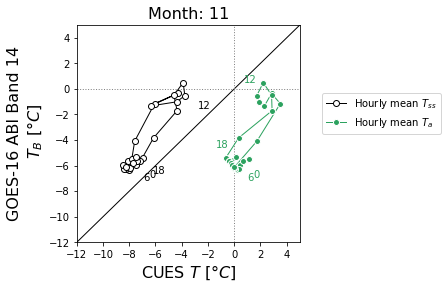

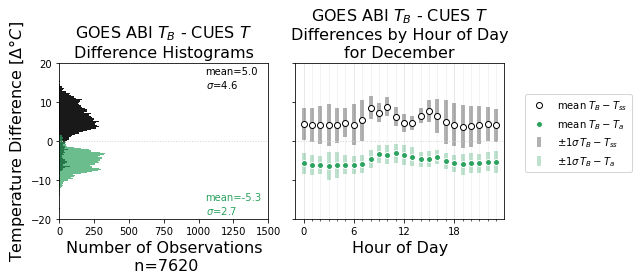

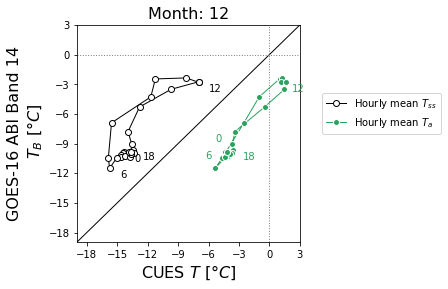

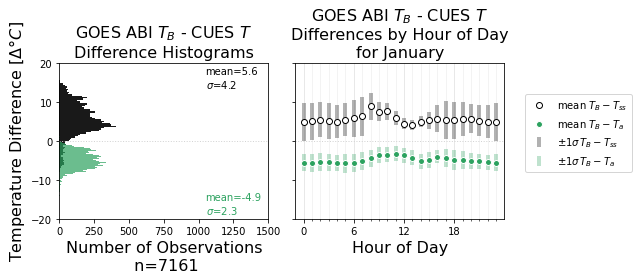

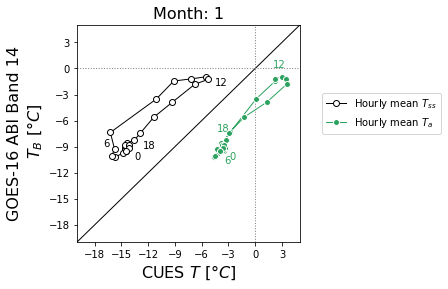

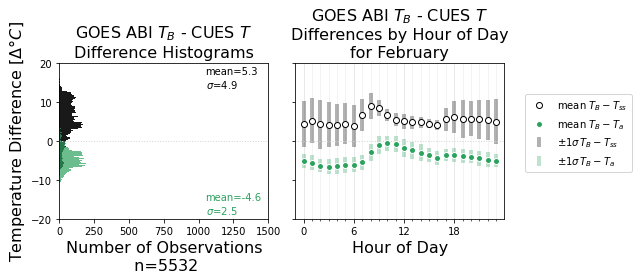

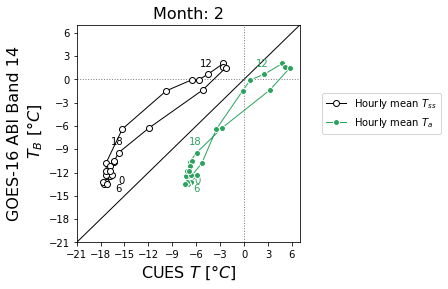

In [18]:
df = cues_snow_abicloud.to_dataframe()

for month in df.index.month.unique():
    month_name = dt.date(1900, month, 1).strftime('%B')
    mask = df.index.month==month
    df_m = df.loc[mask]
    
    # Only look at aggregate months were we have data points (skipping summer months)
    if df_m.goes_cues_diff.count() >= 1:
        
        # Compute summary stats for this aggregated month
        x = df_m['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)']
        x2 = df_m['Platform temperature; platform temperature/relative humidity; (degrees Celsius)']
        y = df_m.goes_tb_c
        print("T_B - T_ss, Month: {}".format(month))
        original_summary_stats = rs.summary_stats(x, y)
        pprint.pprint(original_summary_stats)
        print("T_B - T_air, Month: {}".format(month))
        original_summary_stats2 = rs.summary_stats(x2, y)
        pprint.pprint(original_summary_stats2)
        
        ## Make a 1-to-1 plot for the same data in the histogram
        #plt.figure(figsize=(4,4))
        #plt.title('Month: {}'.format(month))
        #plt.plot(x, y, '.k',alpha=1, markersize=1)
        #(min_lim, max_lim) = (-40, 40)
        #plt.xlim((min_lim,max_lim))
        #plt.ylim((min_lim,max_lim));
        #plt.xlabel('CUES\nSnow Surface Temperature [$\degree C$]')
        #plt.ylabel('GOES-16 ABI Band 14\nBrightness Temperature [$\degree C$]');
        #plt.plot([min_lim,max_lim],[min_lim,max_lim],'-k')

        # Create DataArrayResample object
        resampled_ds = df_m.groupby(df_m.index.hour)
        # Run the resampled_stats function
        resampled_df_tss = rs.resampled_stats(resampled_ds.goes_cues_diff, 0)
        resampled_df_tair = rs.resampled_stats(resampled_ds.goes_cues_airtemp_diff, 0)
        
        # Plot the results
        nbins = 100 #int(np.sqrt(df_m.goes_cues_diff.count()))+1
        #fig, ax = rs.resampled_plot(, ymin=-15, ymax=15, xmin=0, xmax=1600, nbins=nbins)
        
        # Plot the results
        fig, ax = rs.resampled_plot3(df_m.goes_cues_diff, resampled_df_tss,
                                     df_m.goes_cues_airtemp_diff, resampled_df_tair,
                                     ymin=-20, ymax=20, xmin=0, xmax=1500, nbins=nbins)
        
        ax[0].set_title('GOES ABI $T_{B}$ - CUES $T_{}$\nDifference Histograms')
        ax[0].set_ylabel('Temperature Difference [$\Delta\degree C$]')
        ax[1].set_title('GOES ABI $T_{B}$ - CUES $T_{}$\nDifferences by Hour of Day\nfor ' + month_name)
        ax[1].set_xlabel('Hour of Day')
        ax[1].legend(loc=(1.1,.3))
        # Add GOES-ASTER difference by hour of day for this month
        #x = sat_timeseries.index.hour.where(sat_timeseries.index.month==month) # Get hour of day for this month
        #y = sat_timeseries.ast_goes_mean_diff_tb.where(sat_timeseries.index.month==month) # Get GOES-ASTER mean difference for this month
        #yerr_min = y - (sat_timeseries.ast_goes_goes_tb.where(sat_timeseries.index.month==month) - sat_timeseries.ast_goes_min_rad2tbK.where(sat_timeseries.index.month==month))
        #yerr_max = (sat_timeseries.ast_goes_goes_tb.where(sat_timeseries.index.month==month) - sat_timeseries.ast_goes_max_rad2tbK.where(sat_timeseries.index.month==month)) - y
        #ax[1].errorbar(x, y, yerr=[yerr_min, yerr_max], fmt='o', color='r', linewidth=1, capsize=3)
        # Set major ticks and add grid
        ax[1].set_xticks(np.arange(0,24,6))
        ax[1].set_xticks(np.arange(0,24,1), minor = True)
        ax[1].set_xlim((-1,24))
        ax[1].grid(which='major', axis='x', color='lightgrey', lw=1, alpha=0.5);
        ax[1].grid(which='minor', axis='x', color='lightgrey', lw=1, alpha=0.25);
        
        ### add another 1-to-1 plot
        resampled_x_tss = resampled_ds['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)']
        resampled_x_tair = resampled_ds['Platform temperature; platform temperature/relative humidity; (degrees Celsius)']
        resampled_y = resampled_ds.goes_tb_c
        fig3, ax3 = plt.subplots(figsize=(4,4))
        ax3.set_title('Month: {}'.format(month))
        ax3.plot(rs.resampled_stats(resampled_x_tss, 0)['means'], rs.resampled_stats(resampled_y, 0)['means'], linestyle='-',marker='o',markerfacecolor='w',markeredgecolor='k', color='k', lw=1, zorder=99, label='Hourly mean $T_{ss}$')
        ax3.plot(rs.resampled_stats(resampled_x_tair, 0)['means'], rs.resampled_stats(resampled_y, 0)['means'], linestyle='-',marker='o',markerfacecolor='#2ca25f',markeredgecolor='w', color='#2ca25f', lw=1, zorder=99, label='Hourly mean $T_{a}$')

        #ax3.plot(rs.resampled_stats(resampled_x, 0)['medians'], rs.resampled_stats(resampled_y, 0)['medians'], linestyle='none',marker='^',markerfacecolor='none',markeredgecolor='k', zorder=98, label='Hourly Median')
        #ax3.plot(rs.resampled_stats(resampled_x, 0)['modes'], rs.resampled_stats(resampled_y, 0)['modes'], linestyle='none',marker='+',color='k', zorder=97, label='Hourly Mode')
        # Add text labels for each hour
        linregress = stats.linregress(rs.resampled_stats(resampled_x_tss, 0)['means'], rs.resampled_stats(resampled_y, 0)['means'])
        sign = np.array([int(tf) for tf in list(rs.resampled_stats(resampled_y, 0)['means'] > linregress.slope*rs.resampled_stats(resampled_x_tss, 0)['means'] + linregress.intercept)])
        sign[sign==0] = -1
        for i, txt in enumerate(list(rs.resampled_stats(resampled_y, 0).index.values)):
            if i % 6 == 0:
                ax3.annotate(txt, 
                             xy=(rs.resampled_stats(resampled_x_tss, 0)['means'][i]-sign[i]*1, rs.resampled_stats(resampled_y, 0)['means'][i]+sign[i]*1),
                             xytext=(rs.resampled_stats(resampled_x_tss, 0)['means'][i]-sign[i]*1, rs.resampled_stats(resampled_y, 0)['means'][i]+sign[i]*1),
                             fontsize=10) #arrowprops={'width':0, 'headwidth':0})
        # Add text labels for each hour
        linregress = stats.linregress(rs.resampled_stats(resampled_x_tair, 0)['means'], rs.resampled_stats(resampled_y, 0)['means'])
        sign = np.array([int(tf) for tf in list(rs.resampled_stats(resampled_y, 0)['means'] > linregress.slope*rs.resampled_stats(resampled_x_tair, 0)['means'] + linregress.intercept)])
        sign[sign==0] = -1
        for i, txt in enumerate(list(rs.resampled_stats(resampled_y, 0).index.values)):
            if i % 6 == 0:
                ax3.annotate(txt, 
                             xy=(rs.resampled_stats(resampled_x_tair, 0)['means'][i]-sign[i]*1, rs.resampled_stats(resampled_y, 0)['means'][i]+sign[i]*1),
                             xytext=(rs.resampled_stats(resampled_x_tair, 0)['means'][i]-sign[i]*1, rs.resampled_stats(resampled_y, 0)['means'][i]+sign[i]*1),
                             fontsize=10, c='#2ca25f') #arrowprops={'width':0, 'headwidth':0})

        
        
        ## Get ASTER (mean aggregated to GOES pixel size) Tb values for this month
        #x = sat_timeseries.ast_goes_mean_rad2tbK.where(sat_timeseries.index.month==month) - 273.15
        ## Get corresponding GOES value for these ASTER observations
        #y = sat_timeseries.ast_goes_goes_tb.where(sat_timeseries.index.month==month) - 273.15
        #
        ## Get ASTER min and maximum values (these are the min and max values of ASTER pixels under the GOES pixel footprint)
        #xerr_min = x - (sat_timeseries.ast_goes_min_rad2tbK.where(sat_timeseries.index.month==month) - 273.15)
        #xerr_max = (sat_timeseries.ast_goes_max_rad2tbK.where(sat_timeseries.index.month==month) - 273.15) - x
        #
        ## Plot ASTER Tb vs GOES Tb
        #ax3.plot(x, y,  linestyle='none',marker='o',markerfacecolor='r',markeredgecolor='r', label='ASTER vs GOES Tb')
        #
        ## Plot ASTER min/max error bars
        #ax3.errorbar(x, y,
        #         xerr=[xerr_min, xerr_max],
        #         fmt='none', label='min/max ASTER Tb within GOES pixel footprint', color='r', linewidth=1, capsize=3)
    
        
        #ax_lim_min = -25 #min(-5, ax3.get_xlim()[0], ax3.get_ylim()[0])
        #ax_lim_max = 25 #max(5, ax3.get_xlim()[1], ax3.get_ylim()[1])
        ax_lim_min = int(np.min([ ax3.get_xlim()[0], ax3.get_ylim()[0] ])) - 3
        ax_lim_max = int(np.min([999, np.max([ ax3.get_xlim()[1], ax3.get_ylim()[1] ])]) + 1 )
        ax3.plot([ax_lim_min, ax_lim_max],[ax_lim_min, ax_lim_max],linestyle='-',color='k', lw=1)
        ax3.set_xlim((ax_lim_min,ax_lim_max))
        ax3.set_ylim((ax_lim_min,ax_lim_max))
        #ax3.grid('off')
        ax3.axhline(0, color='grey', lw=1, ls=':')
        ax3.axvline(0, color='grey', lw=1, ls=':')
        ax3.get_xaxis().set_major_locator(MaxNLocator(integer=True))  ## Set major locators to integer values
        ax3.get_yaxis().set_major_locator(MaxNLocator(integer=True))  ## Set major locators to integer values
        ax3.set_xlabel('CUES $T$ [$\degree C$]')
        ax3.set_ylabel('GOES-16 ABI Band 14\n $T_{B}$ [$\degree C$]');
        ax3.legend(loc=(1.1,0.5))

In [19]:
#df = cues_snow_abicloud.to_dataframe()
#
#for month in df.index.month.unique():
#    month_name = dt.date(1900, month, 1).strftime('%B')
#    mask = df.index.month==month
#    df_m = df.loc[mask]
#    
#    # Only look at aggregate months were we have data points (skipping summer months)
#    if df_m.goes_cues_diff.count() >= 1:
#        
#        # Compute summary stats for this aggregated month
#        x = df_m['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)']
#        y = df_m.goes_tb_c
#        print("Month: {}".format(month))
#        original_summary_stats = rs.summary_stats(x, y)
#        pprint.pprint(original_summary_stats)
#        # Make a 1-to-1 plot for the same data in the histogram
#        plt.figure(figsize=(4,4))
#        plt.title('Month: {}'.format(month))
#        plt.plot(x, y, '.k',alpha=1, markersize=1)
#        (min_lim, max_lim) = (-40, 40)
#        plt.xlim((min_lim,max_lim))
#        plt.ylim((min_lim,max_lim));
#        plt.xlabel('CUES\nSnow Surface Temperature [$\degree C$]')
#        plt.ylabel('GOES-16 ABI Band 14\nBrightness Temperature [$\degree C$]');
#        plt.plot([min_lim,max_lim],[min_lim,max_lim],'-k')
#
#        # Create DataArrayResample object
#        resampled_ds = df_m.groupby(df_m.index.hour)
#        # Run the resampled_stats function
#        resampled_df = rs.resampled_stats(resampled_ds.goes_cues_diff, 0)
#        
#        # Plot the results
#        nbins = 100#int(np.sqrt(df_m.goes_cues_diff.count()))+1
#        fig, ax = rs.resampled_plot(df_m.goes_cues_diff, resampled_df, ymin=-15, ymax=15, xmin=0, xmax=1600, nbins=nbins)
#        ax[1].set_title('Difference Summary Statistics by Hour of Day for {}'.format(month_name))
#        ax[1].set_xlabel('Hour of Day')
#        ax[1].legend(loc='lower right')
#        # Add GOES-ASTER difference by hour of day for this month
#        #x = sat_timeseries.index.hour.where(sat_timeseries.index.month==month) # Get hour of day for this month
#        #y = sat_timeseries.ast_goes_mean_diff_tb.where(sat_timeseries.index.month==month) # Get GOES-ASTER mean difference for this month
#        #yerr_min = y - (sat_timeseries.ast_goes_goes_tb.where(sat_timeseries.index.month==month) - sat_timeseries.ast_goes_min_rad2tbK.where(sat_timeseries.index.month==month))
#        #yerr_max = (sat_timeseries.ast_goes_goes_tb.where(sat_timeseries.index.month==month) - sat_timeseries.ast_goes_max_rad2tbK.where(sat_timeseries.index.month==month)) - y
#        #ax[1].errorbar(x, y, yerr=[yerr_min, yerr_max], fmt='o', color='r', linewidth=1, capsize=3)
#        # Set major ticks and add grid
#        ax[1].set_xticks(np.arange(0,24,6))
#        ax[1].set_xticks(np.arange(0,24,1), minor = True)
#        ax[1].set_xlim((-1,24))
#        ax[1].grid(which='major', axis='x', color='lightgrey', lw=1, alpha=0.5);
#        ax[1].grid(which='minor', axis='x', color='lightgrey', lw=1, alpha=0.25);
#        
#        ### add another 1-to-1 plot
#        resampled_x = resampled_ds['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)']
#        resampled_y = resampled_ds.goes_tb_c
#        fig3, ax3 = plt.subplots(figsize=(4,4))
#        ax3.set_title('Month: {}'.format(month))
#        ax3.plot(rs.resampled_stats(resampled_x, 0)['means'], rs.resampled_stats(resampled_y, 0)['means'], linestyle='-',marker='o',markerfacecolor='w',markeredgecolor='k', color='k', lw=1, zorder=99, label='Hourly Mean')
#        #ax3.plot(rs.resampled_stats(resampled_x, 0)['medians'], rs.resampled_stats(resampled_y, 0)['medians'], linestyle='none',marker='^',markerfacecolor='none',markeredgecolor='k', zorder=98, label='Hourly Median')
#        #ax3.plot(rs.resampled_stats(resampled_x, 0)['modes'], rs.resampled_stats(resampled_y, 0)['modes'], linestyle='none',marker='+',color='k', zorder=97, label='Hourly Mode')
#        # Add text labels for each hour
#        linregress = stats.linregress(rs.resampled_stats(resampled_x, 0)['means'], rs.resampled_stats(resampled_y, 0)['means'])
#        sign = np.array([int(tf) for tf in list(rs.resampled_stats(resampled_y, 0)['means'] > linregress.slope*rs.resampled_stats(resampled_x, 0)['means'] + linregress.intercept)])
#        sign[sign==0] = -1
#        for i, txt in enumerate(list(rs.resampled_stats(resampled_y, 0).index.values)):
#            if i % 6 == 0:
#                ax3.annotate(txt, 
#                             xy=(rs.resampled_stats(resampled_x, 0)['means'][i]-sign[i]*1, rs.resampled_stats(resampled_y, 0)['means'][i]+sign[i]*1),
#                             xytext=(rs.resampled_stats(resampled_x, 0)['means'][i]-sign[i]*1, rs.resampled_stats(resampled_y, 0)['means'][i]+sign[i]*1),
#                             fontsize=10,
#                            )#arrowprops={'width':0, 'headwidth':0})
#
#        
#        
#        ## Get ASTER (mean aggregated to GOES pixel size) Tb values for this month
#        #x = sat_timeseries.ast_goes_mean_rad2tbK.where(sat_timeseries.index.month==month) - 273.15
#        ## Get corresponding GOES value for these ASTER observations
#        #y = sat_timeseries.ast_goes_goes_tb.where(sat_timeseries.index.month==month) - 273.15
#        #
#        ## Get ASTER min and maximum values (these are the min and max values of ASTER pixels under the GOES pixel footprint)
#        #xerr_min = x - (sat_timeseries.ast_goes_min_rad2tbK.where(sat_timeseries.index.month==month) - 273.15)
#        #xerr_max = (sat_timeseries.ast_goes_max_rad2tbK.where(sat_timeseries.index.month==month) - 273.15) - x
#        #
#        ## Plot ASTER Tb vs GOES Tb
#        #ax3.plot(x, y,  linestyle='none',marker='o',markerfacecolor='r',markeredgecolor='r', label='ASTER vs GOES Tb')
#        #
#        ## Plot ASTER min/max error bars
#        #ax3.errorbar(x, y,
#        #         xerr=[xerr_min, xerr_max],
#        #         fmt='none', label='min/max ASTER Tb within GOES pixel footprint', color='r', linewidth=1, capsize=3)
#    
#        
#        #ax_lim_min = -25 #min(-5, ax3.get_xlim()[0], ax3.get_ylim()[0])
#        #ax_lim_max = 25 #max(5, ax3.get_xlim()[1], ax3.get_ylim()[1])
#        ax_lim_min = int(np.min([ ax3.get_xlim()[0], ax3.get_ylim()[0] ])) - 3
#        ax_lim_max = int(np.min([15, np.max([ ax3.get_xlim()[1], ax3.get_ylim()[1] ])]) + 1 )
#        ax3.plot([ax_lim_min, ax_lim_max],[ax_lim_min, ax_lim_max],linestyle='-',color='k', lw=1)
#        ax3.set_xlim((ax_lim_min,ax_lim_max))
#        ax3.set_ylim((ax_lim_min,ax_lim_max))
#        #ax3.grid('off')
#        ax3.axhline(0, color='grey', lw=1, ls=':')
#        ax3.axvline(0, color='grey', lw=1, ls=':')
#        ax3.get_xaxis().set_major_locator(MaxNLocator(integer=True))  ## Set major locators to integer values
#        ax3.get_yaxis().set_major_locator(MaxNLocator(integer=True))  ## Set major locators to integer values
#        ax3.set_xlabel('CUES\nSnow Surface Temperature [$\degree C$]')
#        ax3.set_ylabel('GOES-16 ABI Band 14\nBrightness Temperature [$\degree C$]');
#        ax3.legend(loc=(1.1,0.5))